In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

In [2]:
# 법령 XML 상세조회 (시행기준. target=eflaw)

#기본 url
url_base = " http://www.law.go.kr/DRF/lawService.do"

#조회 url 세부 설정
user_id = 'bmsong' #open API ID (bmsong@kau.ac.kr의 아이디 부분)
target = "eflaw" #법령 조회시
MST = "218289" #ID 또는 MST #산업안전보건법 MST 218289
#ID = "001766" 
            #ID 산업안전보건법 법령ID 001766 (설명에는 ID로 조회하면 현행법령이 조회된다는데, 
            #target을 eflaw로 하면 ID로 요청해도, MST로 요청해도 같은 것 같다.
Type = "XML" #출력 형태 : HTML 또는 XML

url_sub = "?" +\
        "OC=" + user_id +\
        "&target=" + target +\
        "&MST=" + MST +\
        "&type=" + Type

#최종 url
url = url_base + url_sub

print(url)

response = requests.get(url)

#(1) response.text 사용하는 방법
#soup = BeautifulSoup(response.text.encode('utf-8'), 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)

#(2) response.content 사용하는 방법
soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)


# soup

 http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=eflaw&MST=218289&type=XML


In [3]:
lc_basic_df = pd.DataFrame() #DataFrame for Law Content 

data = soup.find('법령ID') #MST 정보
lc_basic_df['법령ID'] = [data.get_text()]

data = soup.find('법종구분') 
lc_basic_df['법종구분']= [data.get_text()]

data = soup.find('법령명_한글') 
lc_basic_df['법령명']= [data.get_text()]

data = soup.find('시행일자')
lc_basic_df['시행일자'] = [data.get_text()]

data = soup.find('공포일자') 
lc_basic_df['공포일자']= [data.get_text()]

data = soup.find('소관부처') 
lc_basic_df['소관부처']= [data.get_text()]

lc_basic_df

,법령ID,법종구분,법령명,시행일자,공포일자,소관부처
0,001766,법률,산업안전보건법,20210116,20200526,고용노동부


In [4]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)

#         if i.find("항내용"):
#             for j in i.find_all("항내용"):
#                 detail["항문내용"] = j.get_text().strip()
#                 df_info = df_info.append(detail,ignore_index = True)
#                 if i.find("호내용"):
#                     for k in i.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info.head(30)

In [5]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)
        
#         if i.find("항"):
#             for j in i.find_all("항"):
#                 if j.find("항내용"):
#                     detail["항문내용"] = j.항내용.get_text().strip()
#                     df_info = df_info.append(detail,ignore_index = True)
#                 if j.find("호내용"):
#                     for k in j.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info

In [6]:
data = soup.find_all('조문단위')
df_info = pd.DataFrame()
info = []
for i in data:
    info_str = ""
    if i.find("조문여부").get_text() == "조문":
        info_str += i.조문내용.get_text().strip() + ' '
        if i.항:
            hang_nums = i.find_all("항번호")
            ho_nums = i.find_all("호번호")
            if not i.find("항내용") :
                for idx, p in enumerate(i.find_all("호내용")):
                    info_str += p.get_text().split(ho_nums[idx].get_text())[1].strip() + ' '
            else:
                for hang_idx , k in enumerate(i.find_all("항내용")):
                    info_str += k.get_text().strip().split(hang_nums[hang_idx].get_text())[1].strip() + ' '
                for ho_idx , j in enumerate(i.find_all("호내용")):
                    info_str += j.get_text().strip().split(ho_nums[ho_idx].get_text())[1].strip() + ' '
        info.append(info_str)
df_info["조내용"] = info
df_info

,조내용
0,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업..."
3,제4조(정부의 책무) 정부는 이 법의 목적을 달성하기 위하여 다음 각 호의 사항을 ...
4,제5조(사업주 등의 의무) 사업주(제77조에 따른 특수형태근로종사자로부터 노무를 제...
...,...
172,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ..."
175,제174조(형벌과 수강명령 등의 병과) 법원은 제38조제1항부터 제3항까지(제166...


In [7]:
df_info["조내용"][3]

'제4조(정부의 책무) 정부는 이 법의 목적을 달성하기 위하여 다음 각 호의 사항을 성실히 이행할 책무를 진다. <개정 2020.5.26> 정부는 제1항 각 호의 사항을 효율적으로 수행하기 위하여 「한국산업안전보건공단법」에 따른 한국산업안전보건공단(이하 "공단"이라 한다), 그 밖의 관련 단체 및 연구기관에 행정적ㆍ재정적 지원을 할 수 있다. 산업 안전 및 보건 정책의 수립 및 집행 산업재해 예방 지원 및 지도 「근로기준법」 제76조의2에 따른 직장 내 괴롭힘 예방을 위한 조치기준 마련, 지도 및 지원 사업주의 자율적인 산업 안전 및 보건 경영체제 확립을 위한 지원 산업 안전 및 보건에 관한 의식을 북돋우기 위한 홍보ㆍ교육 등 안전문화 확산 추진 산업 안전 및 보건에 관한 기술의 연구ㆍ개발 및 시설의 설치ㆍ운영 산업재해에 관한 조사 및 통계의 유지ㆍ관리 산업 안전 및 보건 관련 단체 등에 대한 지원 및 지도ㆍ감독 그 밖에 노무를 제공하는 사람의 안전 및 건강의 보호ㆍ증진 '

In [8]:
df_info.to_excel('산업안전보건법.xlsx',index = False)

In [9]:
df_info = pd.read_excel("산업안전보건법.xlsx")

# NLP(자연어 처리)



https://konlpy-ko.readthedocs.io/ko/v0.4.4/install/#id1

(konlpy를 사용하기위한 패키지를 다운받는 매뉴얼 입니다)


In [10]:
posts = df_info.get("조내용")
posts

0      제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1      제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2      제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...
3      제4조(정부의 책무) 정부는 이 법의 목적을 달성하기 위하여 다음 각 호의 사항을 ...
4      제5조(사업주 등의 의무) 사업주(제77조에 따른 특수형태근로종사자로부터 노무를 제...
                             ...                        
172    제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173    제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174    제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...
175    제174조(형벌과 수강명령 등의 병과) 법원은 제38조제1항부터 제3항까지(제166...
176    제175조(과태료) 다음 각 호의 어느 하나에 해당하는 자에게는 5천만원 이하의 과...
Name: 조내용, Length: 177, dtype: object

In [11]:
from konlpy.tag import Mecab
tagger = Mecab()

In [12]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
687,해당
688,포함
689,거나
690,하다


In [13]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]

['목적', '법', '안전', '보건', '기준', '확립', '책임', '소재', '재해', '예방']

In [14]:
words = []
for post in posts:
    words.extend(tagger.pos(post))
words[0:10]

[('제', 'XPN'),
 ('1', 'SN'),
 ('조', 'NNG'),
 ('(', 'SSO'),
 ('목적', 'NNG'),
 (')', 'SSC'),
 ('이', 'JKS'),
 ('법', 'NNG'),
 ('은', 'JX'),
 ('산업', 'NNG')]

In [15]:
# 동사 추출
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
verbs[0:10]

['하다', '의하다', '인하다', '걸리다', '정하다', '하다', '맡기다', '받다', '받다', '받다']

In [16]:
# 형용사 추출
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
adjective[0:10]

['같다', '심하다', '있다', '없다', '같다', '같다', '같다', '같다', '같다', '없다']

In [17]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'안전': 601,
 '고용': 442,
 '보건': 368,
 '기관': 224,
 '노동부': 221,
 '노동': 217,
 '부령': 216,
 '근로자': 213,
 '수': 210,
 '사업주': 199,
 '호': 197,
 '필요': 180,
 '작업': 170,
 '물질': 168,
 '밖': 142,
 '건강': 142,
 '관리': 134,
 '유해': 134,
 '조치': 120,
 '진단': 119}

In [18]:
!pip install wordcloud

In [19]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_nouns)

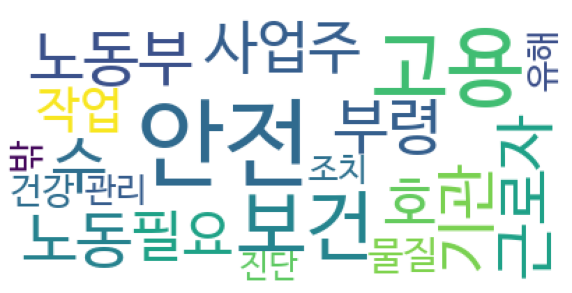

In [20]:
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

# TfidfVectorizer

 TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징이란 것입니다.

In [21]:
# 자주 등장한 명사 20 개 기준
# 각 단어별로 연관성이 계산됨
from sklearn.feature_extraction.text import TfidfVectorizer
tfidv = TfidfVectorizer(sublinear_tf = True).fit(top_nouns)
tfidv.transform(posts).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
# 아예 등장하지 않는다면 0,
# 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것
# 작다면 그다지 가치가 없다고 판단이 가능
pd.DataFrame(tfidv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.652491,0.0,0.0,0.0,0.0,0.000000,0.0,0.652491,0.000000,0.0,0.385372,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.600878,0.0,0.000000,0.799341,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.385372,0.0,0.0,0.0,0.0,0.000000,0.0,0.652491,0.652491,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
173,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
174,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
175,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0


In [23]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer.fit(posts)
# sorted(tfidf_vectorizer.vocabulary_.items())

In [24]:
# tfidfv = TfidfVectorizer().fit_transform(posts)
# tfidfv.toarray()

In [25]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )
print(oo)

[('제', 'Noun'), ('1조', 'Number'), ('(', 'Punctuation'), ('목적', 'Noun'), (')', 'Punctuation'), ('이', 'Noun'), ('법', 'Noun'), ('은', 'Josa'), ('산업', 'Noun'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('에', 'Josa'), ('관', 'Noun'), ('한', 'Josa'), ('기준', 'Noun'), ('을', 'Josa'), ('확립', 'Noun'), ('하고', 'Josa'), ('그', 'Noun'), ('책임', 'Noun'), ('의', 'Josa'), ('소재', 'Noun'), ('를', 'Josa'), ('명확하다', 'Adjective'), ('하다', 'Verb'), ('산업', 'Noun'), ('재해', 'Noun'), ('를', 'Josa'), ('예방', 'Noun'), ('하고', 'Josa'), ('쾌적하다', 'Adjective'), ('작업', 'Noun'), ('환경', 'Noun'), ('을', 'Josa'), ('조', 'Modifier'), ('성함', 'Noun'), ('으로써', 'Josa'), ('노무', 'Noun'), ('를', 'Josa'), ('제공', 'Noun'), ('하다', 'Verb'), ('사람', 'Noun'), ('의', 'Josa'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('을', 'Josa'), ('유지', 'Noun'), ('ㆍ', 'Foreign'), ('증진', 'Noun'), ('함', 'Noun'), ('을', 'Josa'), ('목적', 'Noun'), ('으로', 'Josa'), ('하다', 'Verb'), ('.', 'Punctuation'), ('<', 'Punctuation'), ('개정', 'Noun'), ('2020.5', 'Number'), ('.', '

In [26]:
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stopword=list(stop_words_df.get("불용어"))):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword]
    return(o)

tokenizer_1(posts[80])


['81조',
 '기계',
 '기구',
 '여자',
 '조치',
 '기계',
 '기구',
 '설비',
 '건축물',
 '대여',
 '대여받다',
 '자다',
 '안전',
 '조치',
 '보건',
 '조치']

In [27]:
def tokenizer_2(post):
    nouns = []
  
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
    return nouns

tokenizer_2(posts[0])

['목적',
 '법',
 '안전',
 '보건',
 '기준',
 '확립',
 '책임',
 '소재',
 '재해',
 '예방',
 '작업',
 '환경',
 '조성',
 '노무',
 '제공',
 '사람',
 '안전',
 '보건',
 '유지',
 '목적',
 '개정']

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer=tokenizer_1, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf=True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05308386, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)
#[[1.27771711]]
print(cosine_similarity(X[1], X[2]))#, X)
# [[0.1837195]]

[[1.29799238]]
[[0.15760789]]


# Euclidean Distance(Tfid)

In [30]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [31]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,1.297392,1.414214,1.214639,1.262827,1.352996,1.375911,1.379238,1.338879,1.366074,...,1.357914,1.401841,1.390412,1.383867,1.404749,1.392478,1.414214,1.414214,1.369246,1.358190
1,1.297392,0.000000,1.297992,1.345039,1.214837,1.328928,1.342705,1.358568,1.371692,1.260540,...,1.352222,1.406701,1.368964,1.368213,1.400537,1.385621,1.407068,1.399000,1.378724,1.306488
2,1.414214,1.297992,0.000000,1.400700,1.359254,1.401282,1.414214,1.389349,1.414214,1.367135,...,1.401315,1.405856,1.408438,1.408803,1.405076,1.408757,1.401955,1.410204,1.402135,1.392257
3,1.214639,1.345039,1.400700,0.000000,1.313711,1.284000,1.353715,1.303799,1.288905,1.367633,...,1.382459,1.399548,1.365082,1.377368,1.375361,1.376487,1.408507,1.392977,1.350560,1.358023
4,1.262827,1.214837,1.359254,1.313711,0.000000,1.181294,1.378373,1.360963,1.349446,1.335727,...,1.369940,1.384885,1.368409,1.359715,1.367593,1.357156,1.395656,1.396830,1.363409,1.311417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1.392478,1.385621,1.408757,1.376487,1.357156,1.358936,1.399583,1.401596,1.410855,1.380881,...,1.221786,1.177055,1.264328,1.245160,1.318686,0.000000,1.234893,1.361135,1.283969,1.201176
173,1.414214,1.407068,1.401955,1.408507,1.395656,1.414214,1.414214,1.409081,1.414214,1.385757,...,1.264725,1.263366,1.311720,1.299629,1.248140,1.234893,0.000000,1.251647,1.381730,1.352291
174,1.414214,1.399000,1.410204,1.392977,1.396830,1.394278,1.411981,1.384374,1.411745,1.407132,...,1.316271,1.336282,1.367411,1.371459,1.356511,1.361135,1.251647,0.000000,1.366556,1.381346
175,1.369246,1.378724,1.402135,1.350560,1.363409,1.354268,1.385705,1.379718,1.382236,1.382380,...,1.202060,1.230655,1.290699,1.308788,1.063667,1.283969,1.381730,1.366556,0.000000,1.305763


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


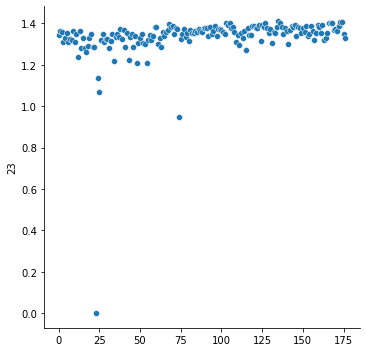

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
x = [i for i in range(len(df_info))]
jo = 24
y_euclidean = euclidean_result_df.get(jo-1)
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.show()


In [33]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:15]

[(24, 0.0),
 (75, 0.9493343592299901),
 (26, 1.0698019144846762),
 (25, 1.1373518245854757),
 (55, 1.2084040290451936),
 (49, 1.210646439975094),
 (35, 1.2157021078910788),
 (44, 1.2245706345201008),
 (13, 1.2389578564899157),
 (18, 1.2603066439730781),
 (116, 1.2734542091091143),
 (17, 1.280821430456887),
 (32, 1.2822134228696587),
 (15, 1.2830746396753236),
 (23, 1.283820196781908)]

# Cosine Similarity(Tfid)

In [34]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [35]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.158387,0.000000,0.262327,0.202635,0.084702,0.053434,0.048851,0.103702,0.066921,...,0.078034,0.017421,0.033377,0.042456,0.013341,0.030502,0.000000,0.000000,0.062582,0.077659
1,0.158387,1.000000,0.157608,0.095435,0.262086,0.116975,0.098571,0.077146,0.059231,0.205519,...,0.085748,0.010596,0.062969,0.063996,0.019247,0.040028,0.010080,0.021399,0.049561,0.146545
2,0.000000,0.157608,1.000000,0.019020,0.076215,0.018204,0.000000,0.034855,0.000000,0.065471,...,0.018158,0.011784,0.008152,0.007637,0.012881,0.007702,0.017262,0.005662,0.017008,0.030811
3,0.262327,0.095435,0.019020,1.000000,0.137081,0.175671,0.083728,0.150054,0.169362,0.064790,...,0.044403,0.020632,0.068275,0.051429,0.054191,0.052642,0.008053,0.029808,0.087994,0.077886
4,0.202635,0.262086,0.076215,0.137081,1.000000,0.302272,0.050043,0.073890,0.089498,0.107916,...,0.061633,0.041047,0.063729,0.075588,0.064845,0.079064,0.026073,0.024433,0.070559,0.140093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.030502,0.040028,0.007702,0.052642,0.079064,0.076646,0.020583,0.017764,0.004744,0.046584,...,0.253620,0.307271,0.200737,0.224788,0.130533,1.000000,0.237520,0.073656,0.175711,0.278589
173,0.000000,0.010080,0.017262,0.008053,0.026073,0.000000,0.000000,0.007246,0.000000,0.039839,...,0.200235,0.201953,0.139695,0.155483,0.221074,0.237520,1.000000,0.216690,0.045411,0.085654
174,0.000000,0.021399,0.005662,0.029808,0.024433,0.027994,0.003155,0.041755,0.003488,0.009989,...,0.133715,0.107175,0.065094,0.059550,0.079939,0.073656,0.216690,1.000000,0.066263,0.045942
175,0.062582,0.049561,0.017008,0.087994,0.070559,0.082979,0.039911,0.048189,0.044711,0.044513,...,0.277526,0.242744,0.167048,0.143537,0.434306,0.175711,0.045411,0.066263,1.000000,0.147492


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


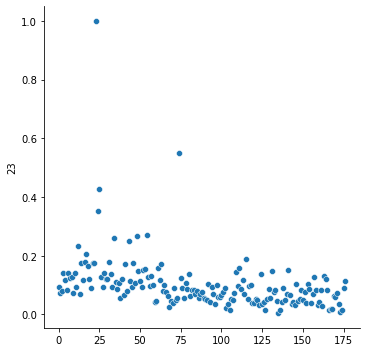

In [36]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [37]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 일치한 값이 도출됨
# [(8, 0.0),
#  (159, 1.1997133735244712),
#  (9, 1.2339850988129575),
#  (141, 1.249947655342399),
#  (116, 1.2588586239691422),
#  (12, 1.273380477935094),
#  (103, 1.2751912213923933),
#  (18, 1.2765253746607559),
#  (47, 1.2834221022776653),
#  (7, 1.2834973950279238)]

[(24, 1.0000000000000004),
 (75, 0.5493821371926924),
 (26, 0.4277619318824612),
 (25, 0.3532154135560449),
 (55, 0.26987985129367154),
 (49, 0.26716759868781575),
 (35, 0.2610341924345939),
 (44, 0.25021338053551906),
 (13, 0.232491714920957),
 (18, 0.2058135815786587)]

# CountVectorizer
가장 단순한 특징으로, 텍스트에서 단위별 등장횟수를 카운팅하여 수치벡터화 하는 것

단위는 문서 단위, 문장 단위, 단어 단위... 가 될 수 있음

가장 많이 사용되는 것은 단어단위의 카운팅

In [38]:
# 빈도높은 상위 20개 명사들로 CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer().fit(top_nouns)
countv.transform(posts).toarray()
top_nouns

{'안전': 601,
 '고용': 442,
 '보건': 368,
 '기관': 224,
 '노동부': 221,
 '노동': 217,
 '부령': 216,
 '근로자': 213,
 '수': 210,
 '사업주': 199,
 '호': 197,
 '필요': 180,
 '작업': 170,
 '물질': 168,
 '밖': 142,
 '건강': 142,
 '관리': 134,
 '유해': 134,
 '조치': 120,
 '진단': 119}

In [39]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,2,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,3,0,0,6,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer(stop_words = list(stop_words_df.get("불용어")))
sp_mat = countv.fit_transform(posts)
# 희소행렬을 np array로
sp_mat.toarray()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '못하다하기보다는', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn('Your stop_words may be in

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
# 단어: 정수인덱스로 구성된 딕셔너리
countv.vocabulary_

{'제1조': 2629,
 '목적': 813,
 '법은': 947,
 '안전': 1584,
 '보건에': 991,
 '기준을': 559,
 '확립하고': 3632,
 '책임의': 3290,
 '소재를': 1379,
 '명확하게': 808,
 '하여': 3502,
 '산업재해를': 1221,
 '예방하고': 1778,
 '쾌적한': 3366,
 '작업환경을': 2209,
 '조성함으로써': 3038,
 '노무를': 600,
 '제공하는': 2963,
 '사람의': 1123,
 '보건을': 992,
 '유지ㆍ증진함을': 1898,
 '목적으로': 816,
 '한다': 3509,
 '개정': 110,
 '2020': 13,
 '26': 14,
 '제2조': 2671,
 '정의': 2347,
 '법에서': 945,
 '사용하는': 1178,
 '용어의': 1828,
 '뜻은': 767,
 '다음과': 625,
 '산업재해': 1219,
 '사람이': 1124,
 '업무에': 1715,
 '관계되는': 352,
 '건설물ㆍ설비ㆍ원재료ㆍ가스ㆍ증기ㆍ분진': 176,
 '등에': 748,
 '의하거나': 1978,
 '작업': 2178,
 '또는': 766,
 '밖의': 852,
 '업무로': 1709,
 '인하여': 2062,
 '사망': 1125,
 '부상하거나': 1073,
 '질병에': 3237,
 '걸리는': 198,
 '것을': 217,
 '말한다': 775,
 '중대재해': 3104,
 '재해': 2247,
 '정도가': 2330,
 '심하거나': 1565,
 '다수의': 623,
 '재해자가': 2253,
 '발생한': 883,
 '경우로서': 248,
 '고용노동부령으로': 283,
 '정하는': 2354,
 '재해를': 2250,
 '근로자': 470,
 '근로기준법': 465,
 '제2조제1항제1호에': 2673,
 '따른': 757,
 '근로자를': 483,
 '사업주': 1151,
 '사용하여': 1180,
 '사업을': 1139,
 '하는': 349

In [42]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,...,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
vectorize = CountVectorizer(
    tokenizer=tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)

print(cosine_similarity(X[1], X[2]))#, X)

[[24.35159132]]
[[0.30615972]]


# Euclidean Distance(CountVectorizer)

In [45]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [46]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,25.039968,8.717798,13.964240,11.313708,7.071068,9.433981,24.372115,12.083046,16.155494,...,8.185353,10.295630,14.933185,13.453624,10.099505,7.745967,5.744563,10.816654,27.748874,58.634461
1,25.039968,0.000000,24.351591,28.284271,24.103942,24.839485,26.191602,33.511192,27.147744,27.166155,...,25.922963,27.037012,27.422618,27.604347,26.925824,26.057628,25.690465,26.758176,36.945906,61.065539
2,8.717798,24.351591,0.000000,17.291616,12.569805,8.602325,10.908712,24.617067,13.638182,16.522712,...,9.539392,11.401754,16.340135,14.594520,11.135529,9.380832,7.549834,11.874342,28.495614,59.648973
3,13.964240,28.284271,17.291616,0.000000,16.401219,15.779734,17.549929,26.514147,17.804494,21.817424,...,17.320508,18.303005,18.973666,19.899749,17.916473,16.822604,16.370706,18.654758,30.116441,57.140179
4,11.313708,24.103942,12.569805,16.401219,0.000000,10.099505,13.820275,24.899799,14.966630,17.804494,...,13.228757,14.560220,17.972201,16.340135,13.711309,12.806248,12.288206,15.198684,27.820855,58.086143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7.745967,26.057628,9.380832,16.822604,12.806248,8.124038,10.049876,24.779023,13.341664,16.522712,...,7.280110,8.246211,14.525839,11.000000,9.273618,0.000000,5.196152,10.246951,27.239677,56.480085
173,5.744563,25.690465,7.549834,16.370706,12.288206,6.557439,8.485281,24.228083,12.124356,15.684387,...,6.164414,8.544004,14.491377,12.083046,8.062258,5.196152,0.000000,9.273618,27.838822,58.898217
174,10.816654,26.758176,11.874342,18.654758,15.198684,11.269428,12.489996,25.826343,15.132746,18.110770,...,10.954451,12.449900,16.000000,14.696938,12.124356,10.246951,9.273618,0.000000,29.103264,58.932164
175,27.748874,36.945906,28.495614,30.116441,27.820855,27.422618,28.618176,34.785054,29.325757,31.192948,...,26.739484,27.092434,29.410882,28.896367,24.000000,27.239677,27.838822,29.103264,0.000000,60.646517


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


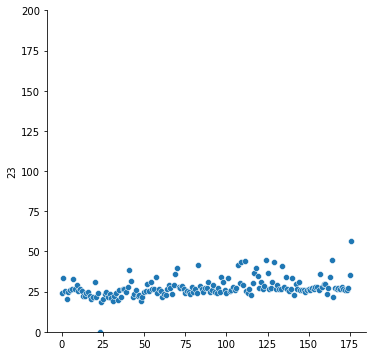

In [47]:
x = [i for i in range(len(df_info))]
jo = 24
y_euclidean = euclidean_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.ylim(0, 200)
plt.show()

In [48]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:10]

[(24, 0.0),
 (25, 18.708286933869708),
 (49, 18.867962264113206),
 (32, 19.28730152198591),
 (35, 19.87460691435179),
 (4, 20.12461179749811),
 (26, 20.346989949375804),
 (19, 20.518284528683193),
 (31, 21.307275752662516),
 (50, 21.37755832643195)]

# Cosine Similarity(CountVectorizer)

In [49]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [50]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.203186,0.052870,0.568535,0.378387,0.221470,0.047378,0.063764,0.178279,0.061602,...,0.058026,0.021383,0.143378,0.075139,0.021932,0.063277,0.000000,0.000000,0.117370,0.245033
1,0.203186,1.000000,0.306160,0.141991,0.355583,0.237855,0.081825,0.092311,0.095499,0.200266,...,0.076635,0.008690,0.158904,0.085496,0.013369,0.038571,0.000000,0.057706,0.046293,0.159843
2,0.052870,0.306160,1.000000,0.076086,0.247566,0.180656,0.000000,0.085333,0.046271,0.105523,...,0.062124,0.030525,0.018606,0.021452,0.046961,0.022582,0.056077,0.014479,0.044350,0.066735
3,0.568535,0.141991,0.076086,1.000000,0.363026,0.263070,0.083333,0.183525,0.228056,0.063041,...,0.037113,0.034192,0.254273,0.076895,0.070138,0.091063,0.025126,0.019462,0.147932,0.289732
4,0.378387,0.355583,0.247566,0.363026,1.000000,0.565660,0.121009,0.190003,0.227673,0.199295,...,0.111153,0.081923,0.122068,0.147134,0.177384,0.148149,0.066890,0.034542,0.223362,0.231945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.063277,0.038571,0.022582,0.091063,0.148149,0.108108,0.020236,0.020426,0.000000,0.042098,...,0.346977,0.456664,0.244959,0.513496,0.262290,1.000000,0.536925,0.190621,0.212320,0.564605
173,0.000000,0.000000,0.056077,0.025126,0.066890,0.000000,0.000000,0.016908,0.000000,0.052271,...,0.369274,0.317526,0.193550,0.382546,0.418718,0.536925,1.000000,0.215166,0.058583,0.341969
174,0.000000,0.057706,0.014479,0.019462,0.034542,0.000000,0.000000,0.013097,0.008877,0.020244,...,0.111237,0.093697,0.185620,0.156391,0.120125,0.190621,0.215166,1.000000,0.037815,0.158933
175,0.117370,0.046293,0.044350,0.147932,0.223362,0.182831,0.052991,0.111434,0.087615,0.055120,...,0.286641,0.247138,0.157934,0.148472,0.568275,0.212320,0.058583,0.037815,1.000000,0.198934


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


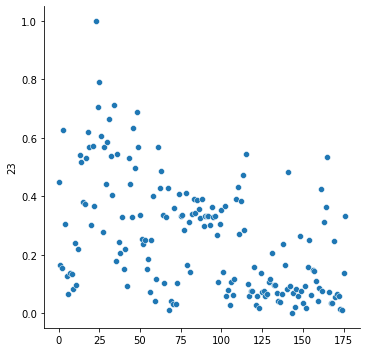

In [51]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [52]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 약간 상이한 도출됨
# [(8, 0.0),
#  (9, 41.71330722922842),
#  (103, 43.69210454990696),
#  (12, 44.384682042344295),
#  (140, 44.68780594300866),
#  (10, 44.78839135311738),
#  (141, 44.91102314577124),
#  (157, 45.155287619502545),
#  (116, 45.21061822182926),
#  (121, 45.221676218380054)]

# tfid
# [(8, 0.0),
#  (159, 1.1997133735244712),
#  (9, 1.2339850988129575),
#  (141, 1.249947655342399),
#  (116, 1.2588586239691422),
#  (12, 1.273380477935094),
#  (103, 1.2751912213923933),
#  (18, 1.2765253746607559),
#  (47, 1.2834221022776653),
#  (7, 1.2834973950279238)]


[(24, 0.9999999999999996),
 (26, 0.7909926907056531),
 (35, 0.7110728784867097),
 (25, 0.7052668604874213),
 (49, 0.6888447509939972),
 (32, 0.6638122983345689),
 (47, 0.6348765006859354),
 (4, 0.6253001102209507),
 (19, 0.6213741946076541),
 (27, 0.604952519174096)]

# SNA

사회 연결망 분석(SNA) : 분석대상(node, vortex)이 서로 어떻게 관계(tie, edge)를 맺고 연
결망(network)을 구성하는가를 분석

사회연결망 분석 -> 의미 연결망분석(Semantic Network Analysis)
* 일정 범위 내 동시출현(co-accurrence)어휘는 서로 연결된 것으로 간주.
분석단위 : 문자, 현태소, 단어, 합성어, 구
동시출현 범위 : 구, 절, 문장, 단락, 문단, 장 , 기사, 문서전체

의미연결망 분석의 인지적 전제
* 두 개 이상의 단어가 서로 가까운 거리에서 배치되어 동시에 출현한다면 그 단어들은 서로 밀접하게 연결되어 의미를 발생한다고 간주.

빈도 분석 vs 의미 연결망 분석
* 특정 단어가 텍스트에서 얼마나 자주 출현하는가를 단순히 계산하기보다, 어떤 단어들이 서로 인접해서 출현하는가가 텍스트의 의미를 더 정교하게 포착한다.

 



In [53]:
import re
import networkx as nx

posts = df_info.get("조내용")
posts

0      제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1      제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2      제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...
3      제4조(정부의 책무) 정부는 이 법의 목적을 달성하기 위하여 다음 각 호의 사항을 ...
4      제5조(사업주 등의 의무) 사업주(제77조에 따른 특수형태근로종사자로부터 노무를 제...
                             ...                        
172    제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173    제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174    제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...
175    제174조(형벌과 수강명령 등의 병과) 법원은 제38조제1항부터 제3항까지(제166...
176    제175조(과태료) 다음 각 호의 어느 하나에 해당하는 자에게는 5천만원 이하의 과...
Name: 조내용, Length: 177, dtype: object

In [54]:
from konlpy.tag import Mecab
# 형태소 분석기 
tagger = Mecab()
stop_words = list(pd.read_excel("stopwords.xlsx").get("불용어"))
stop_words

['아',
 '휴',
 '아이구',
 '아이쿠',
 '아이고',
 '어',
 '나',
 '우리',
 '저희',
 '따라',
 '의해',
 '을',
 '를',
 '에',
 '의',
 '가',
 '으로',
 '로',
 '에게',
 '뿐이다',
 '의거하여',
 '근거하여',
 '입각하여',
 '기준으로',
 '예하면',
 '예를 들면',
 '예를 들자면',
 '저',
 '소인',
 '소생',
 '저희',
 '지말고',
 '하지마',
 '하지마라',
 '다른',
 '물론',
 '또한',
 '그리고',
 '비길수 없다',
 '해서는 안된다',
 '뿐만 아니라',
 '만이 아니다',
 '만은 아니다',
 '막론하고',
 '관계없이',
 '그치지 않다',
 '그러나',
 '그런데',
 '하지만',
 '든간에',
 '논하지 않다',
 '따지지 않다',
 '설사',
 '비록',
 '더라도',
 '아니면',
 '만 못하다',
 '하는 편이 낫다',
 '불문하고',
 '향하여',
 '향해서',
 '향하다',
 '쪽으로',
 '틈타',
 '이용하여',
 '타다',
 '오르다',
 '제외하고',
 '이 외에',
 '이 밖에',
 '하여야',
 '비로소',
 '한다면 몰라도',
 '외에도',
 '이곳',
 '여기',
 '부터',
 '기점으로',
 '따라서',
 '할 생각이다',
 '하려고하다',
 '이리하여',
 '그리하여',
 '그렇게 함으로써',
 '하지만',
 '일때',
 '할때',
 '앞에서',
 '중에서',
 '보는데서',
 '으로써',
 '로써',
 '까지',
 '해야한다',
 '일것이다',
 '반드시',
 '할줄알다',
 '할수있다',
 '할수있어',
 '임에 틀림없다',
 '한다면',
 '등',
 '등등',
 '제',
 '겨우',
 '단지',
 '다만',
 '할뿐',
 '딩동',
 '댕그',
 '대해서',
 '대하여',
 '대하면',
 '훨씬',
 '얼마나',
 '얼마만큼',
 '얼마큼',
 '남짓',
 '여',
 '얼마간',
 '약간',
 '다소',
 '좀',
 '조

In [55]:
# 불용어 제거후 명사만 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in stop_words:
            nouns.append(noun)
            
nouns[0:10]

['목적', '법', '안전', '보건', '기준', '확립', '책임', '소재', '재해', '예방']

In [56]:
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns

{'안전': 601,
 '고용': 442,
 '보건': 368,
 '기관': 224,
 '노동부': 221,
 '노동': 217,
 '부령': 216,
 '근로자': 213,
 '수': 210,
 '사업주': 199,
 '호': 197,
 '필요': 180,
 '작업': 170,
 '물질': 168,
 '밖': 142,
 '건강': 142,
 '관리': 134,
 '유해': 134,
 '조치': 120,
 '진단': 119}

In [57]:
# 문장별로 나눔
sentences = []
for post in posts:
    sentences.extend(re.split('; |\.|\?|\!', post))
sentences[0:20]

['제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를 명확하게 하여 산업재해를 예방하고 쾌적한 작업환경을 조성함으로써 노무를 제공하는 사람의 안전 및 보건을 유지ㆍ증진함을 목적으로 한다',
 ' <개정 2020',
 '5',
 '26> ',
 '제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다',
 ' <개정 2020',
 '5',
 '26> "산업재해"란 노무를 제공하는 사람이 업무에 관계되는 건설물ㆍ설비ㆍ원재료ㆍ가스ㆍ증기ㆍ분진 등에 의하거나 작업 또는 그 밖의 업무로 인하여 사망 또는 부상하거나 질병에 걸리는 것을 말한다',
 ' "중대재해"란 산업재해 중 사망 등 재해 정도가 심하거나 다수의 재해자가 발생한 경우로서 고용노동부령으로 정하는 재해를 말한다',
 ' "근로자"란 「근로기준법」 제2조제1항제1호에 따른 근로자를 말한다',
 ' "사업주"란 근로자를 사용하여 사업을 하는 자를 말한다',
 ' "근로자대표"란 근로자의 과반수로 조직된 노동조합이 있는 경우에는 그 노동조합을, 근로자의 과반수로 조직된 노동조합이 없는 경우에는 근로자의 과반수를 대표하는 자를 말한다',
 ' "도급"이란 명칭에 관계없이 물건의 제조ㆍ건설ㆍ수리 또는 서비스의 제공, 그 밖의 업무를 타인에게 맡기는 계약을 말한다',
 ' "도급인"이란 물건의 제조ㆍ건설ㆍ수리 또는 서비스의 제공, 그 밖의 업무를 도급하는 사업주를 말한다',
 ' 다만, 건설공사발주자는 제외한다',
 ' "수급인"이란 도급인으로부터 물건의 제조ㆍ건설ㆍ수리 또는 서비스의 제공, 그 밖의 업무를 도급받은 사업주를 말한다',
 ' "관계수급인"이란 도급이 여러 단계에 걸쳐 체결된 경우에 각 단계별로 도급받은 사업주 전부를 말한다',
 ' "건설공사발주자"란 건설공사를 도급하는 자로서 건설공사의 시공을 주도하여 총괄ㆍ관리하지 아니하는 자를 말한다',
 ' 다만, 도급받은 건설공사를 다시 도급하는 자는 제외한다',
 ' "건설공사"란 다음 각 목의 어느 하나에 해당하는 공사

In [58]:
# 위에서 구한 문장에서 명사만 추출
sentences_nouns = []
for sentence in sentences:
    sentence_nouns = tagger.nouns(sentence)
    sentences_nouns.append(sentence_nouns)
sentences_nouns[0:10]

[['조',
  '목적',
  '법',
  '산업',
  '안전',
  '보건',
  '기준',
  '확립',
  '책임',
  '소재',
  '산업',
  '재해',
  '예방',
  '작업',
  '환경',
  '조성',
  '노무',
  '제공',
  '사람',
  '안전',
  '보건',
  '유지',
  '목적'],
 ['개정'],
 [],
 [],
 ['조', '정의', '법', '사용', '용어', '뜻', '다음'],
 ['개정'],
 [],
 ['산업재',
  '노무',
  '제공',
  '사람',
  '업무',
  '관계',
  '건설물',
  '등',
  '작업',
  '밖',
  '업무',
  '사망',
  '부상',
  '질병',
  '것',
  '말'],
 ['중대',
  '재해',
  '산업',
  '재해',
  '중',
  '사망',
  '등',
  '재해',
  '정도',
  '다수',
  '재해자',
  '발생',
  '경우',
  '고용',
  '노동',
  '부령',
  '재해',
  '말'],
 ['근로자', '란', '근로', '기준', '법', '조제', '항', '호', '근로자', '말']]

In [133]:
# 상위 단어에대해 id 적용
# 상위단어 top_nouns에 대하여 key에 해당하는 단어, value에 해당하는 id를 넣어 
# 딕셔너리 형태로 저장
word2id = {w: i for i, w in enumerate(range(1,len(df_info)+1))} 
# word2id = {w: i for i, w in enumerate(range(1,10+1))}  # 1조부터 10조까지만 보기위해
word2id

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

In [134]:
id2word = {i: w for i, w in enumerate(range(1,len(df_info)))}
# id2word = {i: w for i, w in enumerate(range(1,10+1))}
id2word

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

In [128]:
cosine_result_df.loc[0:10,0:10]

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.203186,0.052870,0.568535,0.378387,0.221470,0.047378,0.063764,0.178279,0.061602,0.323029
1,0.203186,1.000000,0.306160,0.141991,0.355583,0.237855,0.081825,0.092311,0.095499,0.200266,0.123977
2,0.052870,0.306160,1.000000,0.076086,0.247566,0.180656,0.000000,0.085333,0.046271,0.105523,0.025618
3,0.568535,0.141991,0.076086,1.000000,0.363026,0.263070,0.083333,0.183525,0.228056,0.063041,0.378785
4,0.378387,0.355583,0.247566,0.363026,1.000000,0.565660,0.121009,0.190003,0.227673,0.199295,0.236821
5,0.221470,0.237855,0.180656,0.263070,0.565660,1.000000,0.242833,0.136174,0.263053,0.221016,0.183963
6,0.047378,0.081825,0.000000,0.083333,0.121009,0.242833,1.000000,0.285484,0.373182,0.354606,0.275480
7,0.063764,0.092311,0.085333,0.183525,0.190003,0.136174,0.285484,1.000000,0.446443,0.315513,0.208550
8,0.178279,0.095499,0.046271,0.228056,0.227673,0.263053,0.373182,0.446443,1.000000,0.301914,0.361243
9,0.061602,0.200266,0.105523,0.063041,0.199295,0.221016,0.354606,0.315513,0.301914,1.000000,0.226851


# 인접행렬 생성
상위 단어들에 대해서 상위 갯수만큼의 인접행렬을 만들고, 문장내에 상위 단어가 함께 포함된 비중에 따라 가중치를 계산하여 행렬에 표현한다.
인접 행렬을 생성하기 위해서 이전에 생성해준 word2id를 이용한다. 행렬에서 만약 가중치가 0 이상이면 서로 연결되어 있음을 의미한다.

In [129]:
import numpy as np
adjacent_matrix = np.zeros((num_top_nouns, num_top_nouns), int)
for sentence in sentences_nouns:
    for wi, i in word2id.items():
        if wi in sentence:
            for wj, j in word2id.items():
                if i != j and wj in sentence:
                    adjacent_matrix[i][j] += 1
adjacent_matrix

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [130]:
# 각각에대한 인접행렬의 weight 값을 구함
network = nx.from_numpy_matrix(adjacent_matrix)
list(network.adjacency())


[(0, {}),
 (1, {}),
 (2, {}),
 (3, {}),
 (4, {}),
 (5, {}),
 (6, {}),
 (7, {}),
 (8, {}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {}),
 (13, {}),
 (14, {}),
 (15, {}),
 (16, {}),
 (17, {}),
 (18, {}),
 (19, {})]

In [141]:
# 각각에대한 인접행렬의 weight 값을 구함
boundary = 0.8
same_law = 0.999999
temp_df = cosine_result_df
# temp_df = cosine_result_df.loc[0:9,0:9]
temp_df = temp_df[temp_df>=boundary].fillna(0)
temp_df = temp_df[temp_df <= same_law].fillna(0)

network = nx.from_numpy_matrix(temp_df.to_numpy())
list(network.adjacency())



# def cosine_network(network_list,boundary):
#     for i in network_list:
#         for j in i[1]:
#             if (i[1][j]['weight'] < boundary) or (i[1][j]['weight'] >=0.9999999):
#                 i[1][j]['weight'] = 0
#     return network_list

# cosine_network(network_list,boundary)


[(0, {}),
 (1, {}),
 (2, {}),
 (3, {}),
 (4, {}),
 (5, {}),
 (6, {}),
 (7, {}),
 (8, {}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {}),
 (13, {}),
 (14, {}),
 (15, {}),
 (16, {}),
 (17, {21: {'weight': 0.8220758603149212}}),
 (18, {}),
 (19, {}),
 (20, {}),
 (21, {17: {'weight': 0.8220758603149212}}),
 (22, {}),
 (23, {}),
 (24,
  {25: {'weight': 0.8248992571433379}, 26: {'weight': 0.8489777449916159}}),
 (25, {24: {'weight': 0.8248992571433379}}),
 (26, {24: {'weight': 0.8489777449916159}}),
 (27, {}),
 (28, {30: {'weight': 0.8193738264185371}}),
 (29, {}),
 (30, {28: {'weight': 0.8193738264185371}}),
 (31, {32: {'weight': 0.8008631692433433}}),
 (32, {31: {'weight': 0.8008631692433433}}),
 (33, {}),
 (34, {}),
 (35, {}),
 (36, {}),
 (37, {}),
 (38, {}),
 (39, {}),
 (40, {}),
 (41, {}),
 (42, {}),
 (43, {}),
 (44, {45: {'weight': 0.8711309772938203}}),
 (45, {44: {'weight': 0.8711309772938203}}),
 (46, {47: {'weight': 0.8248366235323719}}),
 (47, {46: {'weight': 0.8248366235323719}}),
 (

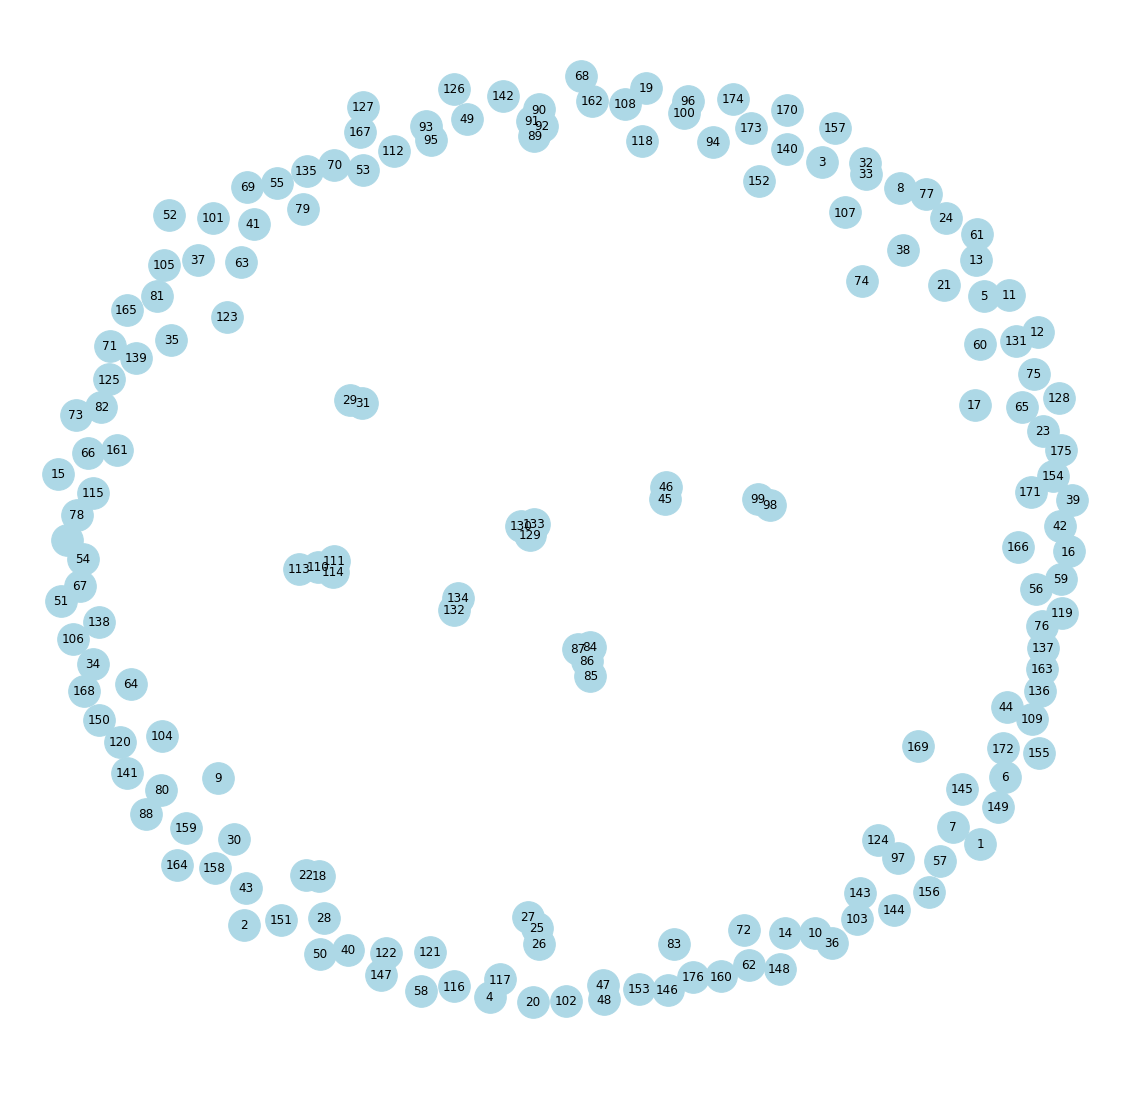

In [142]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
import matplotlib

# matplotlib.font_manager._rebuild()

# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = "NanumGothic"



font_path='./font/NanumGothicCoding.ttf'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
matplotlib.rc('font',family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['font.family'] = "AppleGothic"



# font_path="./font/NanumGothic.ttf"
# font_name = fm.FontProperties(fname=font_path, size=50).get_name()
# plt.rc('font', family=font_name)

# nx.set_fontproperties(font_prop)
fig = plt.figure()
fig.set_size_inches(20, 20)
ax = fig.add_subplot(1, 1, 1)
# ax.axis("off")
# ax.set_title("ㅎㅏ이",fontproperties=font_prop)
option = {
    'node_color' : 'lightblue',
    'node_size' : 1000,

}
nx.draw(network, labels=id2word, font_family=font_name,ax=ax, **option)

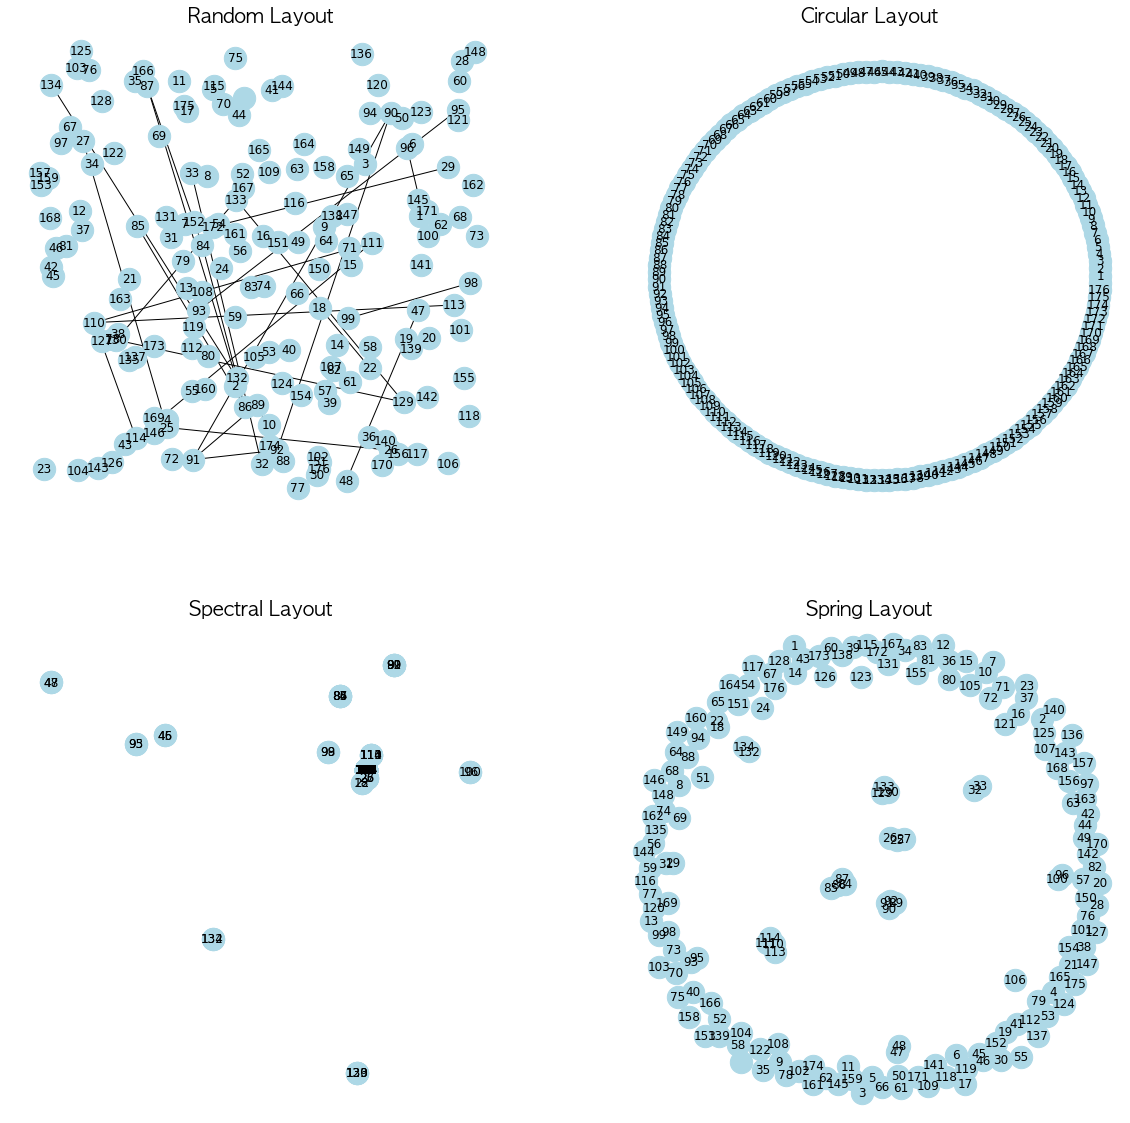

In [143]:
fig = plt.figure()
fig.set_size_inches(20, 20)
option = {
    'node_color' : 'lightblue',
    'node_size' : 500
}

plt.subplot(221)
plt.title('Random Layout', fontsize=20)
nx.draw_random(network, labels=id2word, font_family=font_name, **option)
plt.subplot(222)
plt.title('Circular Layout', fontsize=20)
nx.draw_circular(network, labels=id2word, font_family=font_name, **option)
plt.subplot(223)
plt.title('Spectral Layout',fontsize=20)
nx.draw_spectral(network, labels=id2word, font_family=font_name, **option)
plt.subplot(224)
plt.title('Spring Layout',fontsize=20)
nx.draw_spring(network, labels=id2word, font_family=font_name, **option)